# **Running a Lasso Regression to identify important variables in determing insurance claim charges.**

### 1.) Importing data into a new Google Colab file

In [1]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/insurance.csv')

In [4]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [20]:
df1 = df.copy()   #creating a copy to retain original data

In [6]:
df1.loc[df1["sex"]=="female","sex"] = 1
df1.loc[df1["sex"]=="male","sex"] = 0

In [22]:
#cleaning data and labeling categorical data

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df1["region"] = le.fit_transform(df["region"])
df1["smoker"] = le.fit_transform(df["smoker"])
df1

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,3,16884.92400
1,18,0,33.770,1,0,2,1725.55230
2,28,0,33.000,3,0,2,4449.46200
3,33,0,22.705,0,0,1,21984.47061
4,32,0,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,1,10600.54830
1334,18,1,31.920,0,0,0,2205.98080
1335,18,1,36.850,0,0,2,1629.83350
1336,21,1,25.800,0,0,3,2007.94500


### 2.) Splitting the data into 80/20, for creating training/testing datasets.

In [5]:
import numpy as np

In [23]:
data = np.array(df1.iloc[:,:-1])   #array of predictor variables


In [24]:
target = np.array(df.iloc[:,-1])    #array of response variable

In [27]:
cut = int((len(data) * .8)//1)

In [32]:
#training data
in_data = data[:cut]
in_target = target[:cut]

#testing data
out_data = data[cut:]
out_target = target[cut:]

### 3.) Normalize the Data

In [11]:
from sklearn import preprocessing

In [33]:
scaler = preprocessing.StandardScaler().fit(in_data)

In [36]:
in_data_scale = scaler.transform(in_data)    #giving each beta an opportunity to be relevant
out_data_scale = scaler.transform(out_data)

In [40]:
in_data_scale

array([[-1.45390122,  1.02077653, -0.47403991, -0.90286618,  1.99417757,
         1.34066165],
       [-1.52464584, -0.97964634,  0.4911621 , -0.06353793, -0.50145986,
         0.4373191 ],
       [-0.81719959, -0.97964634,  0.36455128,  1.61511857, -0.50145986,
         0.4373191 ],
       ...,
       [-0.03900872, -0.97964634,  1.95211949, -0.90286618, -0.50145986,
        -1.36936599],
       [ 1.65886228, -0.97964634, -1.50008089, -0.06353793, -0.50145986,
        -0.46602344],
       [ 1.02216066,  1.02077653,  0.18367867, -0.06353793, -0.50145986,
         0.4373191 ]])

### 4.) Get lambda from Lasso cross validation

In [43]:
from sklearn.linear_model import LassoCV

In [44]:
modCV = LassoCV().fit(in_data_scale, in_target)

In [45]:
a = modCV.alpha_  #optimised lambda

In [46]:
a

133.34880015958146

### 5.) Run a regression with that Lambda

In [48]:
from sklearn.linear_model import Lasso

In [49]:
model = Lasso(alpha = a).fit(in_data_scale, in_target)

### 6.) Visualize the coefficients 

In [53]:
#the beta coefficients from lasso regression
model.coef_

array([3564.26137833,    0.        , 1890.8527485 ,  398.24050447,
       9324.84227138, -326.52198757])

In [66]:
coeffs = (df1.columns[:-1])  #getting the name of columns for plotting

In [63]:
import matplotlib.pyplot as plt

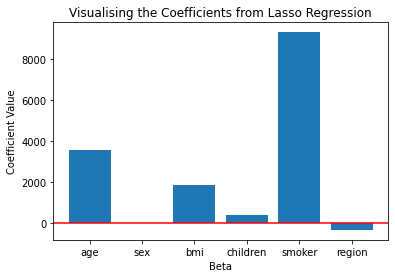

In [70]:
plt.bar(coeffs, model.coef_)
plt.axhline(0, color = "red")
plt.title("Visualising the Coefficients from Lasso Regression")
plt.xlabel("Beta")
plt.ylabel("Coefficient Value")
plt.show()

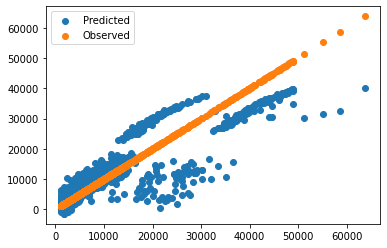

In [88]:
#in-sample predictions
plt.scatter(in_target, model.predict(in_data_scale))
plt.scatter(in_target, in_target)
plt.legend(['Predicted', 'Observed'])
plt.show()

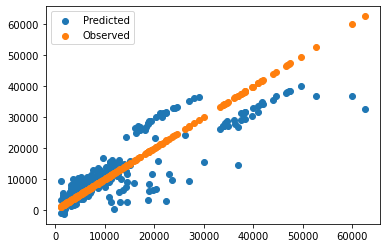

In [89]:
#out-sample predictions
plt.scatter(out_target, model.predict(out_data_scale))
plt.scatter(out_target, out_target)
plt.legend(['Predicted', 'Observed'])
plt.show()

The above graphs show that there is high error in both training and testing datasets when running the Lasso regression model with a lambda ~ 133. The errors can be identified as gaps between the orange and blue scatters.

### 7.) Understanding the coefficients

The above plot shows that "smoker" variable is the most important variable to predict the charges. Followed by "smoker", age and bmi are also importnat predictors.

We also find that sex is rejected by the model and does not have an impact on charges. Further, region has a negative impact on charges.

### 8.) Compare in and out of sample MSE’s

In [71]:
from sklearn.metrics import mean_squared_error

In [76]:
#in sample mse
in_mse = mean_squared_error(model.predict(in_data_scale), in_target)

In [80]:
print("In sample MSE: ", round(in_mse,2))

In sample MSE:  36490415.1


In [79]:
#out sample mse
out_mse = mean_squared_error(model.predict(out_data_scale), out_target)

print("Out of sample MSE: ", round(out_mse,2))

Out of sample MSE:  37252730.72
